In [1]:
import logging
import csv

# Section aware importer of a PPMS data file
def readPPMSDataFile(file):
    rv = {}
    with open(file, newline="") as f:
        r = csv.reader(f,delimiter=',')
        hdr = []
        data = []
        section = None
        for l in r:
            if len(l) > 0:
                if l[0].lower() == '[Header]'.lower():
                    section = hdr
                elif l[0].lower() == '[Data]'.lower():
                    section = data
                elif len(l[0]) > 0 and l[0][0] == ';':
                    pass # ignore commented out lines
                elif section != None:
                    section.append(l)
                else:
                    logging.warning("No section yet defined for line: %s", l)
            else:
                logging.info("Ignoring empty line: %s", l)
        rv['header'] = hdr
        rv['data'] = data
    return rv

# Get the names of all the header variables
def getHeaders(fileData):
    rv = None
    if 'header' in fileData:
        rv = []
        for l in fileData['header']:
            # no need to check len(l) > 0 since our file reader already dealt with that
            rv.append(l[0])
    return rv
   
# Get the value of a named header variable
def getHeaderValue(fileData, name):
    rv = None
    if 'header' in fileData:
        for l in fileData['header']:
            # no need to check len(l) > 0 since our file reader already dealt with that
            if l[0].lower() == name.lower():
                if len(l) > 1:
                    val = ''.join(l[1:])
                else:
                    val = ''
                if rv is None:
                    rv = []
                rv.append(val)
    if (len(rv) > 1):
        return rv
    return rv[0]

# Get the names of the available data columns
def getDataColumns(fileData):
    rv = None
    if 'data' in fileData and len(fileData['data']) > 0:
        rv = fileData['data'][0]
    return rv

# Get the entries stored in one data column
def getDataColumn(fileData, name, prefixMatching=True):
    rv = None
    if 'data' in fileData:
        headers = None
        nameIndex = None
        headerName = None
        for l in fileData['data']:
            if headers is None:
                headers = l
                for i,h in enumerate(headers):
                    if ((prefixMatching and len(h) >= len(name) and h[0:len(name)].lower() == name.lower()) or
                       (not prefixMatching and h.lower() == name.lower())):
                        if nameIndex is None:
                            nameIndex = i
                            headerName = h
                            rv = []
                        else:
                            logging.warning("Ambiguous column selected: %s and %s both match %s", headerName, h, name)
            elif nameIndex != None:
                if len(l) > nameIndex:
                    try:
                        rv.append(float(l[nameIndex]))
                    except ValueError:
                        rv.append(l[nameIndex])
                else:
                    rv.append(None)
                    logging.warning("Unusually short line in data section: %s", l)
    return rv

In [114]:
import numpy as np

curFile = readPPMSDataFile("input.dat")
temp = getDataColumn(curFile,"Sample Temp (Kelvin)")
cp = getDataColumn(curFile,"Samp HC (")

xy = np.array([temp,cp],dtype=np.float64)
xy = xy[:,~(np.isnan(xy).any(axis=0))]
temp = xy[0]
cp = xy[1]

<IPython.core.display.Javascript object>


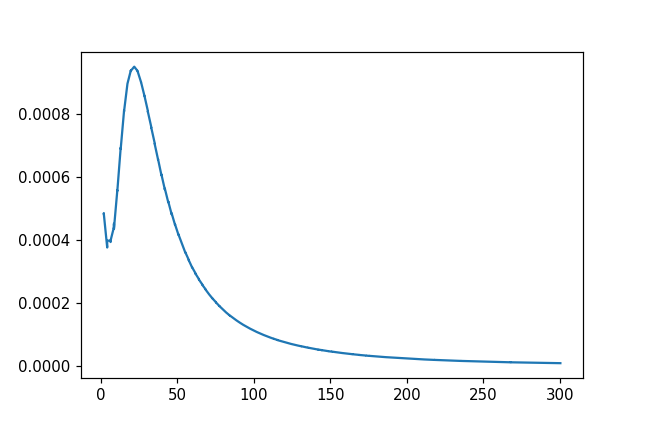

In [115]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(temp,cp/temp**3)

In [120]:
import scipy.integrate
import scipy.interpolate
#
# from Tari, Specific Heat of Matter at Low Tmperatures
#
def einstein(T, T_E):
    R = 8.314 # J/mol-K (also get scipy.constants)
    return 3*R*(T_E/T)**2 * np.exp(-(T_E/T))/(1.0-np.exp(-(T_E/T)))**2

def debyeIntegralSlow(r):
    return scipy.integrate.quad(lambda x: x**4*np.exp(-x)/(1.0-np.exp(-x))**2, 0, r)[0]

rtmp = np.array(range(0,2000))/100+0.005
rtmpy = []
for a in rtmp:
    rtmpy.append([a,debyeIntegralSlow(a)])
rtmpy = np.vstack([np.array([0.0,0.0]),rtmpy,np.array([np.inf, debyeIntegralSlow(50)])])
debyeIntegral = scipy.interpolate.interp1d(rtmpy[:,0],rtmpy[:,1])

def debye(T, T_D):
    R = 8.314 # J/mol-K
    return 9*R*(T/T_D)**3*np.vectorize(debyeIntegral)(T_D/T)

<IPython.core.display.Javascript object>


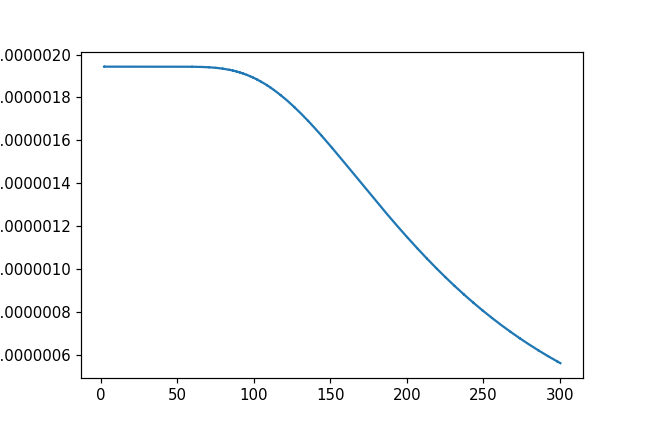

In [121]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(temp,debye(temp,1000)/temp**3)

In [122]:
import scipy.optimize

def combined2DebyeEinstein(temp,sD1,TD1,sD2,TD2,sE,TE):
    # returns C
    return (sD1*debye(temp,TD1)+sD2*debye(temp,TD2)+sE*einstein(temp,TE))
def fitFunc(temp,sD1,TD1,sD2,TD2,sE,TE):
    c = combined2DebyeEinstein(temp,sD1,TD1,sD2,TD2,sE,TE)
    return np.transpose(np.stack([c,c/temp,c/temp**2,c/temp**3])).ravel()

cpfit = np.transpose(np.stack([cp,cp/temp,cp/temp**2,cp/temp**3])).ravel()
sigs = np.transpose(np.stack([1/np.ones(temp.shape),1/temp,1/temp**2,1/temp**3])/100.0)
fit = scipy.optimize.curve_fit(fitFunc,temp,cpfit,sigma=sigs.ravel(),p0=[4,300,6,800,1,100],bounds=(0.0,np.inf))

In [123]:
print(fit[0])

[  3.0630196  287.83117261   4.96893626 726.76727521   1.65853559
 108.90965359]


<IPython.core.display.Javascript object>


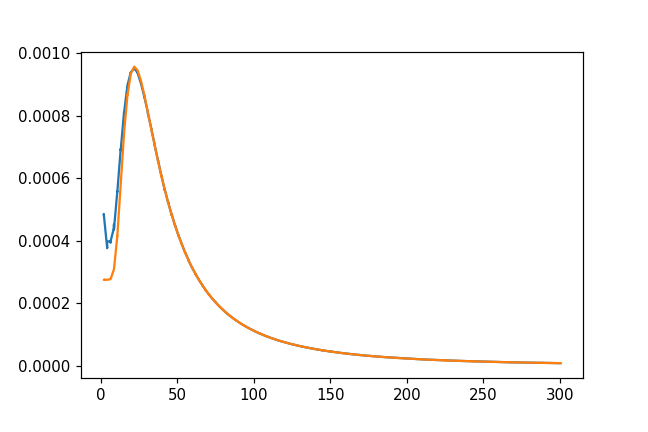

In [125]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(temp,np.transpose([cp/temp**3,combined2DebyeEinstein(temp,*fit[0])/temp**3]))